In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context =   _create_unverified_https_context
    
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from matplotlib import pyplot
from gensim.models import KeyedVectors
import pandas as pd
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /Users/akin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/akin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load dataset 
import pickle
with open('/Users/akin/Desktop/Desktop/dev/course-recommender/catalog.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df = pd.DataFrame(df, 
                  columns=['subject code', 'course number', 
                           'course title', 'course description'])

In [4]:
print(df.shape)

(4619, 4)


In [5]:
df.head(5)

,subject code,course number,course title,course description
0,AAP,3099,Special Topics in AAP,\n Topics TBA.\n
1,AAS,1100,Introduction to Asian American Studies,\n This interdisciplinary course of...
2,AAS,2620,Introduction to Asian American Literature,\n This course will introduce both ...
3,AAS,3312,Afro-Asia: Futurism and Feminism,\n This course explores cultural re...
4,AAS,3378,Korean American Literature,\n The rapidly growing literature o...


In [6]:
# Print random course title and description
print(df['course title'][1])
print(df['course description'][1].strip())

Introduction to Asian American Studies
This interdisciplinary course offers an introduction to the study of Asian/Pacific Islanders in the U.S. This course will examine, through a range of disciplines (including history, literary studies,&nbsp;film/media, performance, anthropology, sociology), issues and methods that have emerged from Asian American Studies since its inception in the late 1960s, including the types of research questions and methods that the study of Asians & Pacific Islander peoples in the U.S. as well as politics and historical relations in the Asia/Pacific region have to offer. In this course, we will pay particular attention to the role of culture and its production in documenting histories, formulating critical practices, and galvanizing political efforts. Topics and themes include: war & empire; queer & feminist lives and histories; refugee, adoptees, transnational families, and other forms of kinship & belonging; anti-Asian violence; settler colonialism and postc

In [7]:

# Print random course title and description
print(df['course title'][3233])
print(df['course description'][3233].strip())

Designing Data Products
This course will help students to gain the necessary skills of building a data product and using AI (artificial intelligence). Many industries today are faced with high data volumes and there is an understanding that "data is the new gold". Business or customer value is not created by data; but rather, it is created by the application of data, ML (machine learning) and deep learning AI. This course trains students to link the possibilities of data and AI to business needs. This course will be held over seven class sessions of double-period length. These classes will be a combination of lectures, discussions, interviews, hands on training with data and AI and peer reviews. At the end of this course students will build their own AI driven product.


<AxesSubplot: >

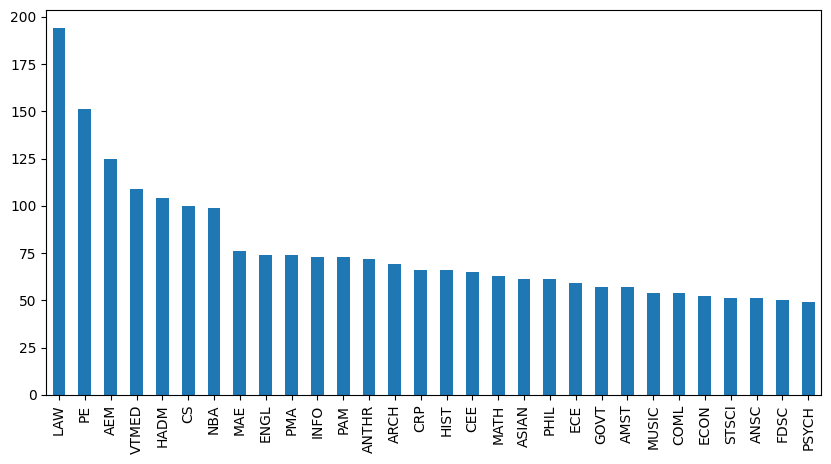

In [8]:
df['subject code'].value_counts()[:30].plot(
    x = 'subject code', y ='count', kind = 'bar', figsize = (10,5)  )

Interesting findings above. Law has the most number of courses at Cornell for SP23

In [9]:
# Pre-processing
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [10]:
df['desc'] = df['course description'].apply(_removeNonAscii)
df['desc'] = df.desc.apply(func = make_lower_case)
df['desc'] = df.desc.apply(func = remove_stop_words)
df['desc'] = df.desc.apply(func=remove_punctuation)
df['desc'] = df.desc.apply(func=remove_html)

In [11]:
df.head(5)

,subject code,course number,course title,course description,desc
0,AAP,3099,Special Topics in AAP,\n Topics TBA.\n,topics tba
1,AAS,1100,Introduction to Asian American Studies,\n This interdisciplinary course of...,interdisciplinary course offers introduction s...
2,AAS,2620,Introduction to Asian American Literature,\n This course will introduce both ...,course introduce variety writings asian north ...
3,AAS,3312,Afro-Asia: Futurism and Feminism,\n This course explores cultural re...,course explores cultural representations afro ...
4,AAS,3378,Korean American Literature,\n The rapidly growing literature o...,rapidly growingliteratureof thekoreandiaspora ...


In [12]:
# Print random course title and description after cleaning
print(df['desc'][1])

interdisciplinary course offers introduction study asian pacific islanders u s course examine range disciplines including history literary studies nbsp film media performance anthropology sociology issues methods emerged asian american studies since inception late 1960s including types research questions methods study asians pacific islander peoples u s well politics historical relations asia pacific region offer course pay particular attention role culture production documenting histories formulating critical practices galvanizing political efforts topics themes include war empire queer feminist lives histories refugee adoptees transnational families forms kinship belonging anti asian violence settler colonialism postcolonial critique


## TF-IDF Word2Vec Model


In [13]:
# Tokenize words
corpus = []
for words in df['desc']:
    corpus.append(word_tokenize(words))
    

In [14]:
#Building TFIDF model and calculate TFIDF score for descriptions
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df = 5, stop_words='english')
tfidf.fit(df['desc'])


# Getting the words from the TF-IDF model
tfidf_list = dict(zip(tfidf.get_feature_names_out(), list(tfidf.idf_)))
tfidf_feature = tfidf.get_feature_names_out()

In [15]:
# Using google pretrained Word2vec model with over 2 billion words
model_file = "/Users/akin/Desktop/Desktop/dev/course-recommender/GoogleNews-vectors-negative300-SLIM.bin.gz"

In [16]:
pretrained_model = KeyedVectors.load_word2vec_format(model_file, binary=True)

In [17]:
model = Word2Vec(vector_size=300, window=5, min_count=1, workers=4)
model.build_vocab(corpus)

In [18]:
model.build_vocab([list(pretrained_model.key_to_index.keys())], update=True)

In [19]:
model.train(corpus, total_examples=model.corpus_count, epochs=5)

(1097270, 1097270)

In [27]:
import bz2

In [20]:
with open('model.pkl', 'wb') as f:
  pickle.dump(model, f)

In [21]:
# Averaging the vectors of each word to get sentence embeddings is not the best
# approach, so this is using the tfidf vectors to weight it.
tfidf_vectors = []
line = 0;

for desc in corpus:
  sent_vec = np.zeros(300)
  weight_sum = 0
  for word in desc:
    if word in model.wv.key_to_index and word in tfidf_feature:
      vec = model.wv[word]
      tf_idf = tfidf_list[word] * (desc.count(word) / len(desc))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
  if weight_sum != 0:
        sent_vec /= weight_sum
  tfidf_vectors.append(sent_vec)
  line += 1

In [108]:
with open('vectors.pkl', 'wb') as f:
  pickle.dump(tfidf_vectors, f)

In [24]:
def recommend_from_keyword(keywords):
    
    keywords = [word_tokenize(keywords)]
    
    keyword_vectors = []


    for line in keywords:
        avgword2vec = None
        count = 0
        for word in line:
            if word in model.wv.key_to_index :
                count += 1
                if avgword2vec is None:
                    avgword2vec = model.wv[word]
                else:
                    avgword2vec = avgword2vec + model.wv[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
        
            keyword_vectors.append(avgword2vec)
                    
    cosine_similarities = cosine_similarity(keyword_vectors, tfidf_vectors)
    avg_scores = cosine_similarities.mean(axis=0)
    top_recommendations = np.argsort(avg_scores)[::-1][:20]
    courses = df['course title']
    df_recommended = []
    for i in top_recommendations:
        df_recommended.append(df.iloc[i])
    return pd.DataFrame(df_recommended, columns=['subject code', 'course number', 
                           'course title'])

In [25]:
recommend_from_keyword('machine learning')

,subject code,course number,course title
2459,INFO,5368,Practical Applications in Machine Learning (PAML)
2461,INFO,5375,Machine Learning for Health
1398,CS,7792,Special Topics in Machine Learning
1608,EDUC,2210,Designing and Facilitating Learning for Develo...
1941,GDEV,2210,Designing and Facilitating Learning for Develo...
1387,CS,6789,Foundations of Reinforcement Learning
1367,CS,5780,Introduction to Machine Learning
1337,CS,4780,Introduction to Machine Learning
4332,SYSEN,5880,Industrial Big Data Analytics and Machine Lear...
4338,SYSEN,6880,Industrial Big Data Analytics and Machine Lear...


In [57]:
def recommend_from_title(title):
      cosine_similarities = cosine_similarity(tfidf_vectors,  tfidf_vectors)
      courses = df[['course title', 'subject code', 'course number']]
      indices = pd.Series(df.index, index = df['course title'])
        
      idx = indices[title]
      # Temporary fix : some courses titles are duplicated. 
      # Trying to keep the duplicates because they come from
      # different departments. 
      if isinstance(idx, pd.core.series.Series):
            idx = idx[0]
      sim_scores = list(enumerate(cosine_similarities[idx]))
      sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
      sim_scores = sim_scores[1:21]
      course_indices = [i[0] for i in sim_scores]
      recommend = courses.iloc[course_indices]
      return recommend

In [58]:
recommend_from_title('Chemical Kinetics and Reactor Design').head(10)

,course title,subject code,course number
1045,Undergraduate Projects in Chemical Engineering,CHEME,4900
1053,Special Projects in Chemical Engineering,CHEME,5999
1067,Chemical Engineering Seminar,CHEME,7900
1022,Computational Methods in Chemistry,CHEM,4810
1026,Computational Methods in Chemistry,CHEM,5810
1004,General Chemistry II,CHEM,2080
739,Chemical Ecology,BIOEE,3690
836,Chemical Ecology,BIONB,3690
1778,Chemical Ecology,ENTOM,3690
1049,Design Project,CHEME,5650
